# PC5228 Analysis

In this file I will do the analysis of the results of Mach-Zehnder interferometer-like Quantum circuit from `PC5228_data_generation.ipynb`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
import scipy
from scipy.optimize import curve_fit

First, let us plot the counts (more beautifully this time).

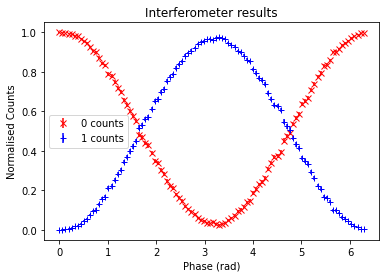

In [2]:
steps = 100
phases = np.linspace(0, 2*np.pi, num=steps)
counts_0 = np.loadtxt('data//counts_0.txt')
counts_1 = np.loadtxt('data//counts_1.txt')
err_counts_0 = np.ndarray(100)
err_counts_1 = np.ndarray(100)

for i in range(100):
    zero = counts_0[i]/2048
    one = counts_1[i]/2048
    err_counts_0[i] = np.sqrt(zero*(1-zero)/2048)
    err_counts_1[i] = np.sqrt(one*(1-one)/2048)


plt.errorbar(phases, counts_0/2048, yerr=err_counts_0, label='0 counts', fmt='rx')
plt.errorbar(phases, counts_1/2048, yerr=err_counts_1, label='1 counts', fmt='b+')
plt.title('Interferometer results')
plt.xlabel('Phase (rad)')
plt.ylabel('Normalised Counts')
plt.legend(loc='best')
plt.show()

The error bars are barely there (they are of the order of 0.01). Thus, we can just assume zero uncertainty. Now let us turn our attention to the interferometric visibility (see [here](https://en.wikipedia.org/wiki/Interferometric_visibility) for more information), which can be expressed as

$$
\nu = \frac{I_{max} - I_{min}}{I_{max} + I_{min}}
$$

For a Mach-Zehnder interferometer, this value should ideally be 1 as $I_{min} = 0$ and $I_{max} = 1$. However, we do not live in Plato's idealistic world and our data is noisy and dirty, and thus will not yield such a perfect, integer value.

In [3]:
def visibility(counts):
    max_counts = max(counts)
    min_counts = min(counts)
    return (max_counts - min_counts) / (max_counts + min_counts)

print('Visibility of 0 counts: ', visibility(counts_0))
print('Visibility of 1 counts: ', visibility(counts_1))

Visibility of 0 counts:  0.9485224022878932
Visibility of 1 counts:  0.995995995995996


This is not the best way to calculate visibility. Let us use fitting instead. We try to fit this function

$$
P(\phi)=\frac{1+v\cos(\phi)}{2}
$$

where $v$ is the visibility.

Credits: https://towardsdatascience.com/basic-curve-fitting-of-scientific-data-with-python-9592244a2509

Visibility:  0.9639510045193753
Standard Deviation:  0.0049622838912976785


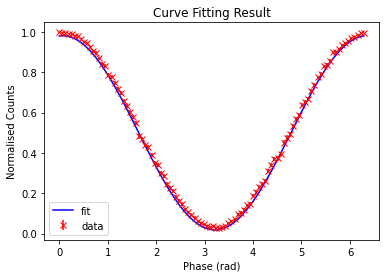

In [4]:
def fit(x, v, d):
    return 1/2 * (1 + v * np.cos(x + d))

# Fit the data
pars, cov = curve_fit(f=fit, xdata=phases, ydata=counts_0/2048, p0=[100, 0], bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))

print("Visibility: ", pars[0])
print("Standard Deviation: ", stdevs[0])

plt.plot(phases, fit(phases, pars[0], pars[1]), '-b', label='fit')
plt.errorbar(phases, counts_0/2048, yerr=err_counts_0, label='data', fmt='rx')
plt.title('Curve Fitting Result')
plt.xlabel('Phase (rad)')
plt.ylabel('Normalised Counts')
plt.legend(loc='best')
plt.show()

With a visibility of 0.96, this is a very good intererence pattern. This little imperfection comes from the noise of the device. In fact, we can run the simulator with the noise model of the machine to get a similar result.

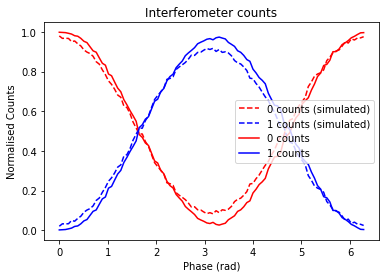

In [5]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

# Get the simulator
simulator = Aer.get_backend('qasm_simulator')

token = 'a4672f03a285b3dc8d9a691a29fb0f2a5bdcc6227d81b073ebec004d7ed7419c7549f68ce21a2cf685575d5f5a2969770a7f0ef4766a6aba0896649d464e2080'
IBMQ.save_account(token, overwrite=True)
provider = IBMQ.load_account()

# This particular result was run on IBMQ Belem
backend = provider.get_backend('ibmq_belem')
noise_model = NoiseModel.from_backend(backend)

# Variables for later use
sim_counts_0 = []
sim_counts_1 = []

for phase in phases:
    # Construct the Mach-Zehnder interferometer
    mzint = QuantumCircuit(1,1)
    mzint.h([0])
    mzint.p(phase, 0)
    mzint.h([0])
    mzint.measure(0, 0)
    
    # Run it on the simulator
    job = execute(mzint, simulator, shots=2048, noise_model=noise_model)
    result = job.result()

    counts = result.get_counts(mzint)
    
    try:
        sim_counts_0.append(counts['0'])
    except KeyError:
        sim_counts_0.append(0)
        
    try:
        sim_counts_1.append(counts['1'])
    except KeyError:
        sim_counts_1.append(0)
        
plt.clf()
plt.plot(phases, np.array(sim_counts_0)/2048, 'r--', label='0 counts (simulated)')
plt.plot(phases, np.array(sim_counts_1)/2048, 'b--', label='1 counts (simulated)')
plt.plot(phases, counts_0/2048, 'r', label='0 counts')
plt.plot(phases, counts_1/2048, 'b', label='1 counts')
plt.title('Interferometer counts')
plt.xlabel('Phase (rad)')
plt.ylabel('Normalised Counts')
plt.legend(loc='right')
plt.show()

In [6]:
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['measure', 'cx', 'x', 'id', 'reset', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('cx', [4, 3]), ('cx', [3, 4]), ('cx', [3, 1]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [1, 2]), ('cx', [1, 0]), ('cx', [0, 1]), ('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('reset', [4]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]
